In [1]:
import os
import cv2
import shutil
import deeplabcut
import numpy as np
import pandas as pd
import subprocess
import datetime 
import math
from joblib import Parallel, delayed
import glob

# import argparse
from matplotlib import pyplot as plt
from PIL import Image
import scipy.stats as stats
# from scipy.linalg import fractional_matrix_power

# import plotly.express as px
# from IPython.display import HTML

# from dash import Dash, dcc, html, Input, Output, no_update, callback
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
import base64
import random

2023-12-06 09:21:27.814339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 09:21:27.928388: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 09:21:28.303098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yramakrishna/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-12-06 09:21:28.303179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic l

Loading DLC 2.3.3...


In [2]:
# Extracting File names, titles and date created to extrach info from their DLC processing

project_name = 'DLC'
your_name = 'YR'

os.chdir('/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids')
h5files = []
vid_to_crop = []

today_1 = datetime.date(2023, 11, 14)
# today_1 = datetime.date.today()
today = str(today_1)
# today = "2023-10-29"
chkdate = today_1.strftime("%b%d")

proj_fold = project_name+'-'+your_name+'-'+today
# print(today)
target = os.path.join(os.getcwd(),proj_fold,'videos')
# print(target)
for file in os.listdir(target):
    if file.endswith("filtered.h5"):
        h5files.append(os.path.join(target,file))
for file in os.listdir(target):   
    if file.endswith("labeled.mp4"):
        vid_to_crop.append(os.path.join(target,file))
        
crop_source = []
if len(h5files)==len(vid_to_crop):
    for i in h5files:
        found = ''
        for j in vid_to_crop:
            x = os.path.splitext(i)[0].rstrip('_filtered.h5')
            y = os.path.splitext(j)[0].rstrip('filtered_labeled.mp4')
            if x==y:
                found = j
        k = os.path.basename(i)
        l = 'DLC' + k.split('DLC')[1] + 'DLC' + k.split('DLC')[2].rstrip('_filtered.h5')

        crop_source.append([i,found, l, chkdate])
c_s = np.array(crop_source)

In [3]:
for i in c_s:
    fl_pth, vid_pth, x, date = i

    cap = cv2.VideoCapture(vid_pth)

    tot_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(vid_pth, tot_frame)

/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-11-14/videos/combined_vids_GCDLC_resnet50_DLCNov14shuffle1_1030000_filtered_labeled.mp4 1869912
/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-11-14/videos/combined_vidsdownsampledDLC_resnet50_DLCNov14shuffle1_1030000_filtered_labeled.mp4 1869919
/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-11-14/videos/combined_vidsdownsampled_72_2_5_5_AGC_claheDLC_resnet50_DLCNov14shuffle1_1030000_filtered_labeled.mp4 1869919


In [37]:
# Extracts confidence of each point in each video, grouped under points.

feature_names = ['RightEye_Pupil','LeftEye_Pupil', 'NostrilsTop_Centre', 'OutlineTop_Mid']#, 'RightEye_Inner', 'LeftEye_Inner']
# feature_names = ['RightEye_Pupil', 'LeftEye_Pupil', 'OutlineTop_Mid', 'NostrilsTop_Centre', 'RightEye_Outer', 'RightEye_Top', 'RightEye_Bottom', 'RightEye_Inner', 'LeftEye_Outer', 'LeftEye_Top', 'LeftEye_Bottom', 'LeftEye_Inner', 'RightNostrils_Top', 'RightNostrils_Bottom','LeftNostrils_Top', 'LeftNostrils_Bottom']


conf = pd.DataFrame()

for i in feature_names:
    df2 = pd.DataFrame()
    mul_cols = []
    for j in c_s:
        fl_pth, vid_pth, x, date = j
        name_check = os.path.basename(vid_pth).split('DLC')[0]
        if name_check.endswith("GC"):
            col_name = "MGC"
        elif name_check.endswith("downsampled"):
            col_name = "NGC"
        else:
            col_name = "AGC"
        tracking_data = pd.read_hdf(fl_pth)
        heading = 'DLC_resnet50_DLC'+ date +'shuffle1_1030000'
        necessary_points = tracking_data[heading][feature_names]
        
        lik = pd.DataFrame(necessary_points[i].likelihood)
        lik = lik.rename(columns={"likelihood" : col_name})
        df2 = pd.concat([df2, lik], axis = 1)
        mul_cols.append((i, col_name))

    df2.columns=pd.MultiIndex.from_tuples(mul_cols)
    conf = pd.concat([conf, df2], axis = 1)


In [38]:
# fl_name = '/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/Confidence_combined_4extracted.csv'

# conf_quarts = pd.read_csv(fl_name, header=[0,1])

conf_quarts = conf

In [39]:
conf_diff = pd.DataFrame()

for i in feature_names:
    df2 = pd.DataFrame()
    cdf = conf[i]
    mul_cols = []
    for j in range(3):
        cur_name = cdf.columns[j]
        prev_name = cdf.columns[j-1]
        col_name = cur_name[0]+prev_name[0]
        diff = pd.DataFrame((cdf[cur_name] - cdf[prev_name]).abs(), columns=[col_name])
        # diff = pd.DataFrame((cdf[cur_name] - cdf[prev_name]), columns=[col_name])
        df2 = pd.concat([df2, diff], axis = 1)
        mul_cols.append((i, col_name))
    df2.columns=pd.MultiIndex.from_tuples(mul_cols)
    conf_diff = pd.concat([conf_diff, df2], axis = 1)

In [40]:
filtx = conf_quarts.xs('NGC', level = 1, axis = 1)
filtx = filtx[filtx.le(0.2).all(axis = 1)]
filtg = conf_diff.loc[filtx.index]
filtb = filtg.xs('AN', level = 1, axis = 1)
filtb = filtb[filtb.gt(0.7).all(axis = 1)]

res = conf_quarts.loc[filtb.index]
pd.options.display.max_rows = 460
# res

In [41]:
# import researchpy as rp
# from pprint import pprint

In [42]:
cutoff = 0.01
    
# filtx = conf_quarts.xs('NGC', level = 1, axis = 1)
# filtx = filtx[filtx.le(cutoff).all(axis = 1)]

print(f"Filtered for NGC and AGC < {cutoff}\n\n")

for i in feature_names:
    print(i)
    subset = conf_quarts[i]
    # pairs = {1: ['MGC', 'AGC'],
             # 2: ['NGC', 'MGC'],
             # 3: ['AGC', 'NGC']}
    # pairs = {1: ['MA'],
    #          2: ['NM'],
    #          3: ['AN']}
    # for j in range(3):
    #     print(pairs[j+1])
    #     # print(stats.wilcoxon(subset[pairs[j+1][0]], subset[pairs[j+1][1]], alternative="two-sided", nan_policy='omit', method='exact', zero_method='zsplit'))
    duo = pd.DataFrame()
    duo = pd.concat([conf_quarts[i]['NGC'], conf_quarts[i]['AGC'], conf_quarts[i]['MGC'], conf_diff[i]['AN'], conf_diff[i]['MA']], axis = 1)
    
    # duo = duo.loc[filtx.index]
    duo = duo[duo['NGC'].gt(cutoff)]
    duo = duo[duo['AGC'].gt(cutoff)]
    # duo = duo[duo['NGC'].le(0.9)]
    # duo = duo[duo['AGC'].gt(0.7)]
    
    
    print(duo.shape)
    print("Mean of NGC - ", np.mean(duo['NGC']))
    print("Std_div of NGC - ", np.std(duo['NGC']))
    print("Std_error of NGC - ", stats.sem(duo['NGC']))
    print()
    print("Mean of MGC - ", np.mean(duo['MGC']))
    print("Std_div of MGC - ", np.std(duo['MGC']))
    print("Std_error of MGC - ", stats.sem(duo['MGC']))
    print()
    print("Mean of AGC - ", np.mean(duo['AGC']))
    print("Std_div of AGC - ", np.std(duo['AGC']))
    print("Std_error of AGC - ", stats.sem(duo['AGC']))
    print()
    print(stats.pearsonr(duo['NGC'], duo['AN']), ' - NGC and AN')
    print(stats.wilcoxon(duo['NGC'], duo['AGC']), ' - NGC and AGC')
    print(stats.ttest_1samp(duo['AN'], popmean=0), ' - of AN\n')
    print(stats.pearsonr(duo['MGC'], duo['MA']), ' - MGC and MA')
    print(stats.wilcoxon(duo['MGC'], duo['AGC']), ' - MGC and AGC')
    print(stats.ttest_1samp(duo['MA'], popmean=0), ' - of MA\n')
    # print(stats.wilcoxon(duo['AN']), 'AN')
    print(stats.f_oneway(duo['NGC'], duo['AGC'], duo['MGC']), ' - of all three(NGC, MGC and AGC)\n\n\n')


Filtered for NGC and AGC < 0.01


RightEye_Pupil
(52060, 5)
Mean of NGC -  0.8941304237221318
Std_div of NGC -  0.25987718594155235
Std_error of NGC -  0.0011389908747215995

Mean of MGC -  0.954641880677667
Std_div of MGC -  0.18495774254293768
Std_error of MGC -  0.0008106336083417721

Mean of AGC -  0.9733702690865991
Std_div of AGC -  0.13831694742829592
Std_error of AGC -  0.0006062161261651009

PearsonRResult(statistic=-0.8748567598341012, pvalue=0.0)  - NGC and AN
WilcoxonResult(statistic=237662667.0, pvalue=0.0)  - NGC and AGC
Ttest_1sampResult(statistic=86.72324321307761, pvalue=0.0)  - of AN

PearsonRResult(statistic=-0.7072821635205045, pvalue=0.0)  - MGC and MA
WilcoxonResult(statistic=539608926.0, pvalue=1.474311506757486e-304)  - MGC and AGC
Ttest_1sampResult(statistic=47.309091499789695, pvalue=0.0)  - of MA

F_onewayResult(statistic=2216.12279063934, pvalue=0.0)  - of all three(NGC, MGC and AGC)



LeftEye_Pupil
(50648, 5)
Mean of NGC -  0.8798302598892085
Std_div of NG

In [10]:
filtx = conf_quarts.xs('NGC', level = 1, axis = 1)
filtx = filtx[filtx.gt(0.70).all(axis = 1)]


duo = conf_quarts
duo = duo.loc[filtx.index]
print(duo.shape)

filty = duo.xs('AGC', level = 1, axis = 1)
filty = filty[filty.gt(0.999).all(axis = 1)]
duo = duo.loc[filty.index]
print(filtx.shape, filty.shape)
print(duo.shape)
print(duo.index)


(37882, 12)
(37882, 4) (14083, 4)
(14083, 12)
Index([    399,     401,     402,     445,     446,     447,     448,     449,
           450,     464,
       ...
       1869223, 1869225, 1869245, 1869247, 1869249, 1869268, 1869279, 1869403,
       1869525, 1869542],
      dtype='int64', length=14083)


In [11]:
def crop_it(frame_numbers):
    path = dict([(1,'/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/GC_Conv_vids/combined_vidsdownsampled_72_2_5_5_AGC_clahe.mp4'),
                (0,'/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/GC_Conv_vids/combined_vidsdownsampled.mp4')])
    video = cv2.VideoCapture(path[0])
    total_frames = len(frame_numbers)
    fps = 30
    
    today_1 = datetime.date.today()
    today = str(today_1)
    
    output_name = os.path.join(os.getcwd(), f'Frames_to_label_{today}.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_name, fourcc, fps, (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    
    frame_number = 0
    origin = []
    
    for j in range(len(frame_numbers)):
        i = frame_numbers[j]
        vid = random.randint(0,1)
        
        cap = cv2.VideoCapture(path[vid])
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            print('Error - frame not retreived')
            continue
        
        origin.append(vid)
        
        out.write(frame)
        cap.release()
        print(round(frame_number/total_frames*100, 2), end = '\r')
        frame_number += 1
        
    video.release()
    out.release()
    cv2.destroyAllWindows()
    print("Done")
    return output_name, origin
    # print('')

In [13]:
frames_needed = duo.index
# file_path = crop_it(frames_needed)

In [14]:
os.getcwd()

'/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids'

In [16]:
# fl_name = os.path.join(os.getcwd(), 'Frame_source_info_2023-12-05.csv')
    
# # open the file in the write mode
# # f = open(fl_name, 'w')

# # write a row to the csv file
# # for i in file_path[1]:
# #     f.write(f'{i}\n')
# #     # print(i)

# data = pd.DataFrame([frames_needed, file_path[1]]).T
# data.to_csv(fl_name, index=False)
# data

In [18]:
import deeplabcut

In [19]:
project_name = 'DLC'
your_name = 'YR'
folder = ['/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/Frames_to_label_2023-12-04.mp4'] 

In [23]:
def process(fold, project_name, your_name):
    file = fold[0]
    print(file)
    bodyparts = ['RightEye_Outer', 'RightEye_Top', 'RightEye_Bottom', 'RightEye_Inner', 'RightEye_Pupil', 'LeftEye_Outer', 'LeftEye_Top', 'LeftEye_Bottom', 'LeftEye_Inner', 'LeftEye_Pupil',
                 'OutlineTop_Mid','RightNostrils_Top', 'RightNostrils_Bottom','LeftNostrils_Top', 'LeftNostrils_Bottom']
    videotype = os.path.splitext(file)[-1].lstrip('.')  # or MOV, or avi, whatever you uploaded!
    video_down = folder
    name_fold = 'Analyse_' + os.path.basename(os.path.dirname(file))
    
    model_options = deeplabcut.create_project.modelzoo.Modeloptions
    model_selection = 'primate_face'

    config_path, train_config_path = deeplabcut.create_pretrained_project(
        project_name,
        your_name,
        video_down,
        videotype=videotype,
        model=model_selection,
        analyzevideo=True,
        createlabeledvideo=False,
        copy_videos=False,
    )

    edits = {
        'dotsize': 1.2,  # size of the dots!
        'pcutoff': 0.4,  # the higher, the more conservative the plotting!
    }
    deeplabcut.auxiliaryfunctions.edit_config(config_path, edits)
    project_path = os.path.dirname(config_path)
    full_video_path = []
    for i in fold:
        full_video_path.append(os.path.join(project_path,'videos', os.path.basename(i)))

    # filter predictions (should already be done above ;):
    deeplabcut.filterpredictions(config_path, full_video_path, videotype=videotype)

    # re-create the video with your edits!
    # deeplabcut.CropVideo(config_path, full_video_path, 'crop', 
    deeplabcut.create_labeled_video(config_path, full_video_path, videotype=videotype, displayedbodyparts=bodyparts, draw_skeleton = True, filtered=True)
    
    

In [21]:
process(folder, project_name, your_name)
# notify("DLC labelling done")

/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/Frames_to_label_2023-12-04.mp4
Created "/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos"
Created "/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/labeled-data"
Created "/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/training-datasets"
Created "/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/dlc-models"
Attempting to create a symbolic link of the video ...
Created the symlink of /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/Frames_to_label_2023-12-04.mp4 to /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos/Frames_to_label_2023-12-04.mp4
/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats

/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/dlc-models/iteration-0/DLCDec5-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/dlc-models/iteration-0/DLCDec5-trainset95shuffle1


/home/yramakrishna/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-12-05 09:55:08.612670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 09:55:08.640646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 09:55:08.640860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-05 09:55:08.641224: I tensorflow/core/platfo

Analyzing all the videos in the directory...
Starting to analyze %  /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos/Frames_to_label_2023-12-04.mp4
Loading  /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos/Frames_to_label_2023-12-04.mp4
Duration of video [s]:  469.43 , recorded with  30.0 fps!
Overall # of frames:  14083  found with (before cropping) frame dimensions:  320 240
Starting to extract posture


  0%|                                                 | 0/14083 [00:00<?, ?it/s]2023-12-05 09:55:09.434785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-12-05 09:55:09.545227: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|████████████████████████████████████| 14083/14083 [00:20<00:00, 692.55it/s]


Saving results in /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos/Frames_to_label_2023-12-04.mp4
Saving filtered csv poses!
Starting to process video: /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos/Frames_to_label_2023-12-04.mp4
Loading /home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/videos/Frames_to_label_2023-12-04.mp4 and data.
Duration of video [s]: 469.4

100%|████████████████████████████████████| 14083/14083 [00:16<00:00, 866.11it/s]


In [17]:
man_lab = pd.read_csv('/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/DLC-YR-2023-12-05/labeled-data/Frames_to_label_2023-12-04/CollectedData_YR.csv', header=[1,2])

In [18]:
origin = pd.read_csv('/home/yramakrishna/DeepLabCut/conda-environments/Codes/Stats_Analysis_AGC/All_vids/Frame_source_info_2023-12-05.csv')

In [19]:
name = man_lab[('Unnamed: 2_level_0', 'Unnamed: 2_level_1')]

frame_no = []

for i in name:
    frame_no.append(int(i.split('img')[1].split('.png')[0]))

In [20]:
frames = origin.iloc[frame_no]
frames.columns = ['frame','gc']

In [21]:
# frames

In [22]:
landmarks = pd.DataFrame()
feature_names = ['RightEye_Pupil','LeftEye_Pupil']

for i in feature_names:
    df2 = pd.DataFrame()
    mul_cols = []
    done = 0
    for j in c_s:
        fl_pth, vid_pth, x, date = j
        name_check = os.path.basename(vid_pth).split('DLC')[0]
        if name_check.endswith("GC"):
            continue
        elif name_check.endswith("downsampled"):
            col_name = "NGC"
        else:
            col_name = "AGC"
        tracking_data = pd.read_hdf(fl_pth)
        trdt = tracking_data.loc[frames.frame]
        necessary_points = trdt[heading][feature_names]
        x = pd.DataFrame(necessary_points[i])
        x = x.drop(['likelihood'], axis = 1)
        x.reset_index(drop=True, inplace=True)
        # print(x)
        if done == 0:
            ml = pd.DataFrame(man_lab[i])
            df2 = pd.concat([df2, ml], axis = 1, ignore_index=True)
            mul_cols.append((i, 'Manual', ml.columns[0]))
            mul_cols.append((i, 'Manual', ml.columns[1]))
            # print(ml)
            done = 1
        
        df2 = pd.concat([df2, x], axis = 1, ignore_index=True)
        mul_cols.append((i, col_name, x.columns[0]))
        mul_cols.append((i, col_name, x.columns[1]))
    
    # print(df2)
    df2.columns=pd.MultiIndex.from_tuples(mul_cols)
    landmarks = pd.concat([landmarks, df2], axis = 1)

In [23]:
landmarks

RightEye_Pupil                                                   
            Manual                     NGC                     AGC   
                 x           y           x           y           x   
0       180.435617   82.586164  181.284348   83.169151  181.774918  \
1       180.473288   81.188769  181.700287   82.271057  181.800446   
2       175.004789   75.173420  175.005936   77.333214  175.568314   
3       177.310788   88.835821  176.722992   87.943520  175.655960   
4       177.050386   84.148579  178.647263   85.876381  178.007278   
5       176.098488   84.469869  176.620056   84.464073  177.534164   
6       176.918763   76.267120  174.174789   74.862869  175.548767   
7       179.654410   69.826448  178.780258   71.183067  178.263367   
8       168.196705   78.159324  170.317154   79.891655  170.319656   
9       159.966416   91.032067  161.264175   92.990486  160.485550   
10      184.301237   78.181095  183.917252   82.724434  183.934830   
11      165.708340   91.305492  166.054184   91.879143  165.997681   
12      187.466481   78.940531  187.907791   80.122124  187.523651   
13      180.746713   80.915344  183.264420   86.682198  182.565628   
14      180.956422   78.159324  182.364487   81.554680  182.197739   
15      194.691385   81.462194  194.668045   80.444115  193.770172   
16      193.976541   80.242543  194.456375   81.392288  191.910080   
17      180.746713   97.047416  180.129105   98.060066  180.463379   
18      175.487972   76.336507  175.626724   79.330688  176.768845   
19      197.882576   97.689502  194.467972   98.949852  194.889465   
20      180.746713   99.781666  175.888916  101.497505  178.481796   
21      181.020138   98.141116  179.903824   99.539330  180.416000   
22      179.653013  103.062765  178.843674  102.646042  179.154648   
23      174.706764  102.637148  173.118759  103.750702  174.308167   
24      -14.345364  180.497459  171.129181   98.619644  172.080627   
25      172.883948   99.512319  172.761414  101.477058  174.339600   
26      180.473288   85.290143  180.860794   86.703819  181.450394   
27             NaN         NaN  163.862076   92.444115  160.844788   
28      162.427241   80.095069  165.222198   87.998184  164.598083   
29      164.067791   93.492892  166.526093   94.490547  166.405685   
30      162.427241   90.758642  161.892441   90.644737  162.390030   
31      169.536290   85.290143  170.472061   86.186256  170.460419   
32      169.238314   88.835821  168.103012   90.133369  169.059433   
33      176.269179   86.492200  176.137924   86.300270  177.237656   
34      181.477226   84.408981  182.595856   89.577095  183.593140   
35      177.310788   86.231798  177.363602   88.250282  177.991058   
36      171.723689   87.750968  172.631729   88.338333  172.229782   
37      167.675900   89.356626  168.849289   91.406349  168.109650   
38      170.629989   90.485217  171.942261   88.750008  172.902985   
39      167.895740   89.391518  170.703110   89.290932  171.183228   
40      167.895740   85.016718  168.401413   86.228477  169.045853   
41      188.129186   66.150397  188.320511   69.599594  187.516510   
42      195.538955   71.128460  191.946716   74.350838  192.874969   
43      185.904067   71.388862  181.938065   72.456329  182.036224   
44      228.089252   80.502945  227.967224   80.375404  228.343719   
45      163.769864   91.179443  164.860031   90.397957  163.863449   
46      158.325867  101.695640  153.761292  105.094322  153.807495   
47      164.811474   85.971395  165.214966   89.179878  166.075043   
48      168.196705   83.627774  170.704941   82.699257  171.324081   
49      169.498717   74.513690  170.423264   75.475243  171.446228   
50      169.238314   81.804957  167.040314   83.687843  168.472748   
51      165.434915   86.383843  166.444412   85.583542  167.176758   
52      161.060116   96.227141  161.866180   96.525253  161.848557   
53      162.467853   91.439845  163.325134   92.471863  163.836517   
54      193.32

In [24]:
comp = ['NGC', 'AGC']

point_diff = pd.DataFrame()
mulcol = []
for i in feature_names:
    root = landmarks[i]['Manual']
    for j in comp:
        mulcol.append((i, j))
        check = landmarks[i][j]
        xdiff = (root['x'] - check['x'])**2
        ydiff = (root['y'] - check['y'])**2
        d = (xdiff + ydiff)**(1/2)
        diff = pd.DataFrame(d, columns=[j])
        point_diff = pd.concat([point_diff, diff], axis = 1)
    # print(point_diff)
# print(mulcol)
point_diff.columns = pd.MultiIndex.from_tuples(mulcol)

In [29]:
total_diff = pd.DataFrame()

for i in feature_names:
    d2 = point_diff[i]['NGC'] - point_diff[i]['AGC']
    d3 = pd.DataFrame(d2, columns=[i])
    total_diff = pd.concat([total_diff, d3], axis = 1)
# total_diff

In [31]:
for i in feature_names:
    print(i)
    tests = pd.DataFrame(total_diff[i])
    tests = tests.dropna()
    # print(tests)
    # print(stats.ttest_rel(tests['NGC'], tests['AGC']))
    # for i in tests.columns:
    print("Mean - ", np.mean(tests[i]))
    print("Std_div - ", np.std(tests[i]))
    print("Std_error - ", stats.sem(tests[i]))
    print(stats.ttest_1samp(tests[i], popmean=0))
    print()

RightEye_Pupil
Mean -  0.36085055105607455
Std_div -  1.6575856722611586
Std_error -  0.09683718894841828
Ttest_1sampResult(statistic=3.726363342168955, pvalue=0.0002330668410018407)

LeftEye_Pupil
Mean -  0.09821002751536906
Std_div -  0.7645283972276903
Std_error -  0.04443731046515785
Ttest_1sampResult(statistic=2.2100803691162407, pvalue=0.027864566145333752)



<Axes: >

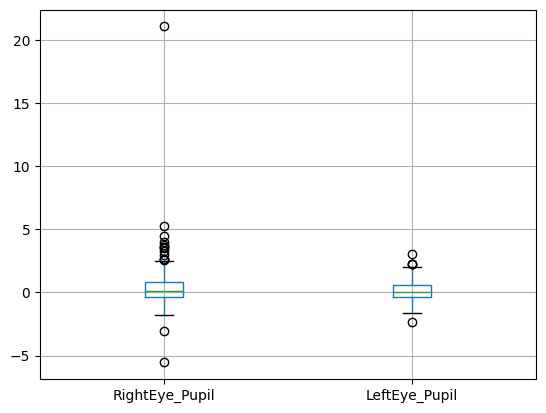

In [35]:
# plt.boxplot(total_diff)
total_diff.boxplot()
